In [395]:
import glob
import sys
import pandas as pd
import numpy as np

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import *
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
#import pandas as pd

In [396]:
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

In [398]:
path = ''
#Just a file of 180 sentences representing conversations between therapist and clients
data_file = 'PTSD_annotated_data1.csv'

separator = ";"


data_df = pd.read_csv(data_file, delimiter=';',encoding = 'ISO-8859-1')
# keep the top 518 rows, as that is what is labeled for now

data_df.head()

,transcript_id,character,text,Keywords / Significant sentences,A1,B1,B2,B3,B4,B5,...,D6,D7,E1,E2,E3,E4,E5,E6,F1,G1
0,PTSD_file_1,CLIENT,Remind me never to go to a work meeting with a...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PTSD_file_1,THERAPIST,Those darn women.,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,PTSD_file_1,CLIENT,Damn women. Our boss is she's just a shut the ...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PTSD_file_1,THERAPIST,It's not that comfortable.,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,PTSD_file_1,CLIENT,What's that?,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [399]:

data_df = data_df.fillna(0)
data_df = data_df.replace('NaN', 0)





['A1', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'F1', 'G1']


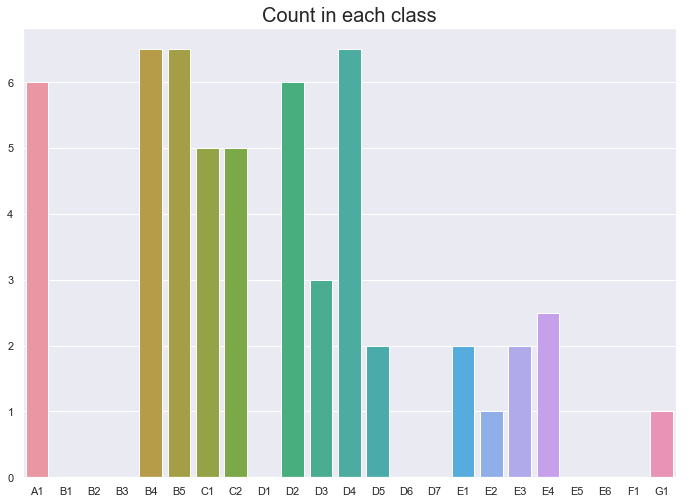

In [400]:

# Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A text might be about any of religion, politics, finance or education at the same time or none of these.
# already have 1 and 0s, and for now, a .5 can be a 1.

import seaborn as sns
import matplotlib as plt

categories = list(data_df.columns.values)
print(categories[4:])
sns.set(font_scale = 2)
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.barplot(categories[4:], data_df.iloc[:,4:].sum().values).set_title('Count in each class', fontsize=20)

labels = data_df.iloc[:,4:].sum().values


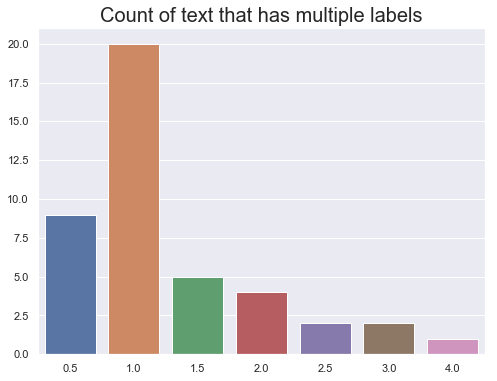

In [401]:
#Count of text that has multiple label
rowSums = data_df.iloc[:,4:].sum(axis=1)

multiLabel_counts = rowSums.value_counts()

multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale = 2)
sns.set(rc={'figure.figsize':(8,6)})
sns.barplot(multiLabel_counts.index, multiLabel_counts.values).set_title('Count of text that has multiple labels', fontsize=20)

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
rects = ax.patches
labels = multiLabel_counts.values


In [402]:
data_df.columns.ne(0.0).any(axis=1)
#data_df['factorA1B1'] = data_df.apply(lambda row: "1" if row['A1']!= 0.0 and row['D4'] != 0.0  else "0", axis=1)  


In [403]:
#data_df[data_df['factorA1B1']!='0']

In [404]:
# continue with guidance from: https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#is based on The Porter Stemming Algorithm
wnl = nltk.stem.WordNetLemmatizer()
stopword = stopwords.words('english')
snowball_stemmer = SnowballStemmer('english')
#function to tokenize, lemmatize, remove non-alpha characters, numbers in time stamps (00), stem, remove stop words

def clean(sentence): 
    sentence = re.sub('[^A-Za-z!0-9]+', ' ', sentence)
    
    sentence = re.sub(r'\d{2}','',sentence)
    
    sentence = sentence.strip()
    
    sentence = [wnl.lemmatize(i) for i in word_tokenize(sentence)]
    
    sentence = [snowball_stemmer.stem(word) for word in sentence]
    
    sentence = [word for word in sentence if word not in stopword]
    

    return sentence

    
    
    

[nltk_data] Downloading package stopwords to /Users/test/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/test/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/test/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [405]:



#loads the text, cleans it, stores it into a list of lists, and calculates word frequency
# changing to use the pandas df
#It returns a list of list containing the tokens
def load_df(df,textcolumn): 
    text_liste = []
    for transcript in df[textcolumn].iteritems():
        
        tokens = clean(transcript[1])
        
        for word in tokens:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1
        text_liste.append(tokens)
    return text_liste
 

In [406]:
#dfnew = data_df[data_df['A1']>0.0]
#Label each line with a category: one that is not null

def recoverText(data_d,category,A):
    
    for cat in category:
        
        for texte in data_d[data_d[cat]>0.0].text:
            A[0].append( texte )
            A[1].append(cat)
            
            #A[2].append(data_d.at[i,'character'] ) 
        for i in list(data_d[data_d[cat]>0.0].index.values):
            A[2].append( data_d.iloc[i].character )    
            
    return A
#Build a dataframe of 3 columns with only lines not null for one category
A = [[],[],[]]   
A = recoverText(data_df,data_df.columns[4:],A)
texte_series = pd.Series(A[0])
categorie_series = pd.Series(A[1])
character_series = pd.Series(A[2])
data_dfNew = pd.DataFrame(character_series)
data_dfNew = pd.concat([data_dfNew, texte_series,categorie_series ],axis=1)
data_dfNew.columns = ['characters','texts','categories']


In [407]:
import random
#Create a new list of list containing lines that have 0 for every category
# We randomly select a fixed number of lines in order to avoid imbalanced
# There too many lines that don't belong to a category
def recoverTextNonCategorized(data_d,A,m,n):
    """ Create a list of lines that have 0 for every category.
        Params:
            the dataframe containing the data
            A list of list that will contain the lines
            m determine the categories we want
            n the fixed number of lines we need
            
        Return:
            A list of list containing the text, the character and a new category called NOT
    """
    choosenj = []
    for i in range(n):
        j = random.choice(list(data_d[data_d.iloc[:,m:].sum(axis=1,skipna=True)==0.0].index.values))
        if j not in choosenj:
            
            texte = data_d.at[j,'text']
            charact = data_d.at[j,'character']
            A[0].append( charact)
            A[1].append(texte )
            A[2].append('NOT'  )
            choosenj.append(j)
        else:
            n = n + 1
            
               
            
    return A
ANOT = [[],[],[]]
ANOT = recoverTextNonCategorized(data_df,ANOT,4,60)


In [408]:
#Create a dataframe containing a fix number of lines that don't belong to any category
df2 = pd.DataFrame(ANOT[0], columns = ['characters'])
df2['texts'] = ANOT[1]
df2['categories'] = ANOT[2]
data_dfNew = data_dfNew.append(df2).reset_index(drop=True)



In [554]:
#Conatenate the two dataframes in order to have some equilibrium that can help avoid imbalance
word_count = {}    
text_list = load_df(data_dfNew,'texts')  





text_list_series = pd.Series(text_list)

df_w_tokens_cat = pd.concat([data_dfNew, text_list_series],axis=1)


df_w_tokens_cat.columns = ['characters','texts','categories','tokens']                                                             





This part of the document is dedicated to some word analysis in tokens with two techiques:
- The co-occurrence matrix thet determine co-occurence of word depending on a window size.
- The word2vec techniques based on Gensin and wv_from_bin from google. 
- We can have a look at the word most used by the client and the therapist
- We can see the context of each word and if we have a word what will be its context

In [410]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    flatten_corpus  = [y for x in corpus for y in x]
    corpus_words = sorted([y for y in set(flatten_corpus)])
    
    num_corpus_words = len(corpus_words )
    # ------------------

    return corpus_words, num_corpus_words

In [411]:

def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
             
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    ##Get the distinct words of a corpus
    words, num_words = distinct_words(corpus)
    
    M = None
    word2Ind = {}
    
    
    M = np.zeros((num_words,num_words))
    # For each distinct word we get its index 
    # and search its index in each element of the corpus
    for word in words:
        
        k = words.index(word)
        word2Ind[word] = k
        #
        for i in range(len(corpus)):
            #If the word is present in an element of the corpus 
            if word in corpus[i]:
                # Get its list of index in this element of the corpus
                listIndex=[j for j in range(len(corpus[i])) if corpus[i][j]== word]
                for x in listIndex:
                    #for each index we look at neighbors depending on the window size
                    for j in range(1,window_size+1):
                        if x-j >= 0:
                            wordneighbor = corpus[i][x-j]
                            l = words.index(wordneighbor)
                            
                            M[k,l] += 1
                        if x + j < len(corpus[i]):
                            wordneighbor = corpus[i][x+j]
                            h = words.index(wordneighbor)
                            
                            M[k,h] += 1
                    
    
    # ------------------

    return M, word2Ind

In [412]:
#Calculate the co-occurrence matrix for each token
df_w_tokens_cat_M,df_w_tokens_cat_C =  compute_co_occurrence_matrix(df_w_tokens_cat.tokens, window_size=4)

In [413]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
        # ------------------
        # Write your implementation here.
    
    svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=42)
    M_reduced = svd.fit(M).transform(M) 

 
        # ----------    



    print("Done.")
    return M_reduced

In [414]:
#Apply SVD to a co-occurence matrix
df_w_tokens_cat_M_reduce = reduce_to_k_dim(df_w_tokens_cat_M, k=2)

Running Truncated SVD over 681 words...
Done.


In [475]:
import matplotlib.pyplot as plt



def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , k)): matrix of k-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    plt.figure(figsize=(20,10))
    for i,word in enumerate(words):
        x = M_reduced[i][0]
        y = M_reduced[i][1]
        plt.scatter(x+0.03, y+0.03, marker='x', color='red')
        plt.text(x, y, word, fontsize=20)
    plt.show()
    # ------------------

In [495]:
from matplotlib import pyplot
def plot_embeddings_pyplot(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , k)): matrix of k-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    pyplot.figure(figsize=(8,8))
    # create a scatter plot of the projection
    
    
    for i, word in enumerate(words):
        pyplot.scatter(M_reduced[i, 0], M_reduced[i, 1],marker='x', color='red')
        pyplot.annotate(word, xy=(M_reduced[i, 0], M_reduced[i, 1]))
    pyplot.show()
    
    # ------------------

/anaconda3/envs/Python37/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


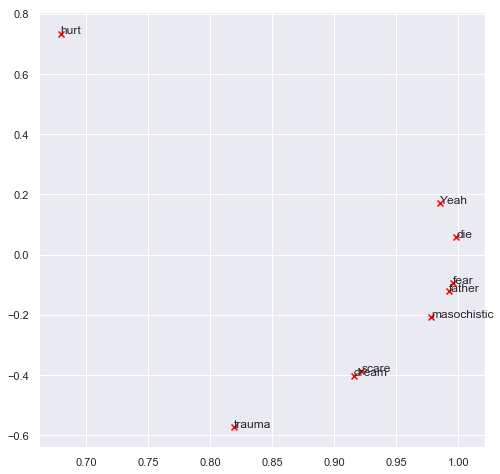

In [555]:
# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(df_w_tokens_cat_M_reduce, axis=1)
M_normalized = df_w_tokens_cat_M_reduce / M_lengths[:, np.newaxis] # broadcasting


words = ['die', 'father', 'trauma', 'fear', 'dream','scare','masochistic','hurt','Yeah']


plot_embeddings_pyplot(M_normalized, df_w_tokens_cat_C, words)

In [497]:
#Depending on val get the word
def  getWord(val):
    keys = []
    for key, value in df_w_tokens_cat_C.items():
        if value == val:
            
            keys.append(key)
    return keys[0]
    

In [498]:
#For each word in the vocabulary, we can see based on the co-occurrence Matrix the words of its context
def getWordNeighborDist(Mat,word_index, word):
    theDict = {}
    if word in list(word_count.keys()):
        indx = word_count[word]
    
        L = list(Mat[indx,:])
        theDict = {getWord(key):value for (key,value) in enumerate(L) if value > 0.0}
    else:
        print("this word not exist in the vocabulary")
    return theDict


    
word = "trauma"

theDict = getWordNeighborDist(df_w_tokens_cat_M,df_w_tokens_cat_C, word)


[1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0]


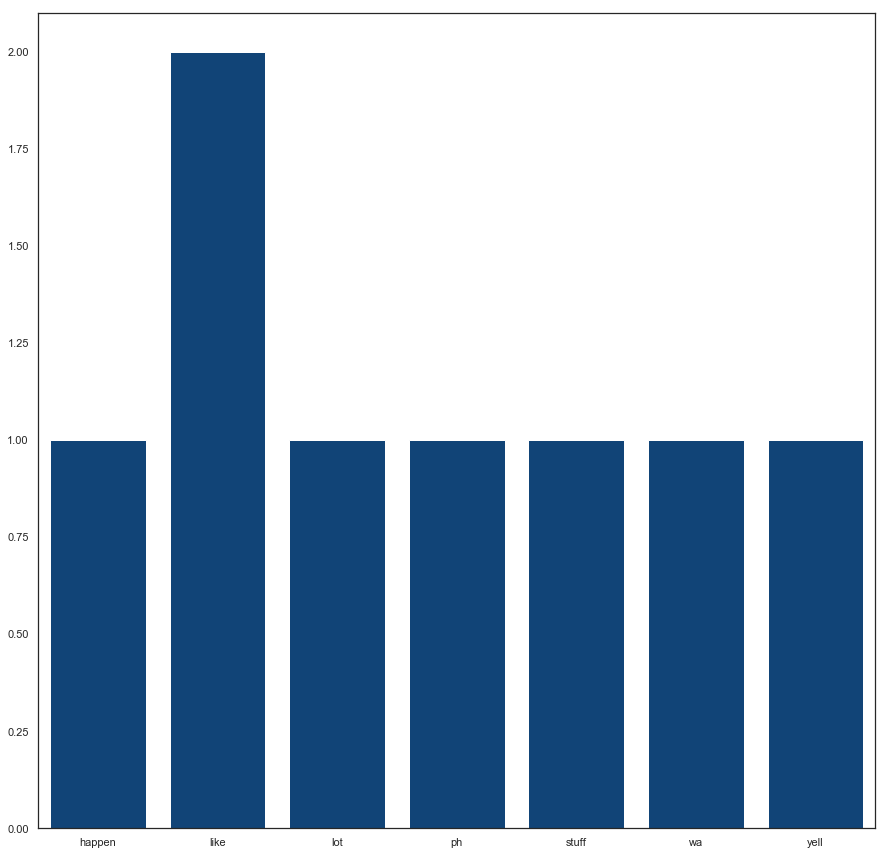

In [499]:
#Plot the context of a word 
def word_relation_plot(theDic):
    if theDic != {}:
        keys = list(theDic.keys())
        vals = list(theDic.values())
        print(vals)
        sns.set(style="white", rc={"lines.linewidth": 3})
        fig, ax1 = plt.subplots(figsize=(15,15))

        sns.barplot(x= keys,
            y= vals, 
            color='#004488',
            ax=ax1)

        plt.show()
        sns.set()
    else:
        print("Nothing to print ")
word_relation_plot(theDict)

In [556]:
#Find the word mostly or leastly used by the client or the therapist

df_tokens_client = df_w_tokens_cat.loc[df_w_tokens_cat['characters']=='CLIENT']
df_tokens_therapist = df_w_tokens_cat.loc[df_w_tokens_cat['characters']=='THERAPIST']

def getWordMostorLeastUsed( dataList, numData,order):
    """ Find words mostly or leastly used by the client or the therapist


        Params:
            dataList: List of list of tokens
            numData: The fixed number of words
            order: determines the mostly or leastly used words
        Return:
            list of words and list of counts of these words
    """
    listwords = []
    listwordsandNum = []
    
    d = dict()
    for listword in dataList:
        for word in listword:
            d[word] = d.get(word,0)+1
    
    i = 0
    for w in sorted(d, key=d.get, reverse=order):
        listwords.append(w)
        listwordsandNum.append((w, d[w]))
        i = i+1
        if i == numData: break
    return listwords,listwordsandNum
    

LUsedWords,LUsedWordsNum = getWordMostorLeastUsed( df_tokens_client['tokens'], 40,False)


#Word2vec techniques in order to learn the context of a word

In [557]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each lengh 300
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    vocab = list(wv_from_bin.vocab.keys())
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin

In [558]:

 
wv_from_bin = load_word2vec()



/anaconda3/envs/Python37/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Loaded vocab size 3000000


In [559]:
#Word To Vec
import random
def get_matrix_of_vectors(wv_from_bin, required_words=['trauma', 'fear']):
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 3 million word2vec vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 300) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [508]:
M, word2Ind = get_matrix_of_vectors(wv_from_bin,LUsedWords)
M_reduced = reduce_to_k_dim(M, k=2)


Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10036 words...
Done.


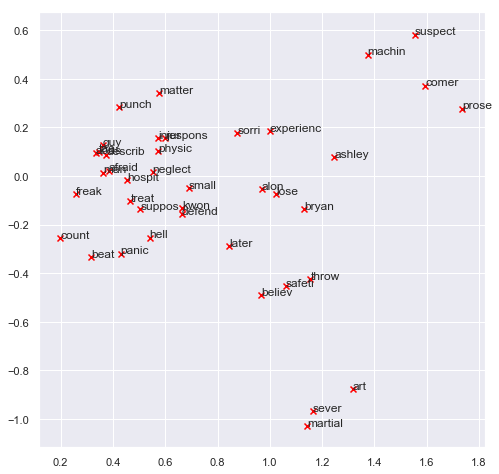

In [510]:
# We used the word leastly used by the client with word2vec and plot the proximity between them
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting


plot_embeddings_pyplot(M_reduced, word2Ind, LUsedWords)

# This part is dedicated to LSTM
- We vectorize the data based on TFIDF
- We detrmine the train and test sample
- We pass it to LSTM RNN model build on keras


In [560]:
# Bag of Words 

from sklearn.model_selection import train_test_split
y = pd.get_dummies(df_w_tokens_cat['categories']).values

X =  df_w_tokens_cat.drop(['texts','categories'],axis=1)
Xtrain,Xtest,ytrain, ytest = train_test_split(X,y, random_state=42, test_size=0.30, shuffle=True)

# consider a stratified test/train split, and/or temporal

def dummy_fun(doc):
    return doc

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    analyzer='word', 
    ngram_range=(1,3), 
    norm='l2',     
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)


vectorizer.fit(Xtrain['tokens'])
vectorizer.fit(Xtest['tokens'])

x_train = vectorizer.transform(Xtrain['tokens'])

x_test = vectorizer.transform(Xtest['tokens'])

print('Shape of label tensor:', y.shape)
#print(categories[4:])
print(x_train.shape)


Shape of label tensor: (133, 15)
(93, 1655)


In [552]:
import keras
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.models import Sequential
model = Sequential()
model.add(Embedding(94, 1655))

model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(15, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


history = model.fit(x_train, ytrain,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 74 samples, validate on 19 samples
Epoch 1/10
74/74 [==============================] - 24s 325ms/step - loss: 2.7367 - acc: 0.0000e+00 - val_loss: 2.5196 - val_acc: 0.6842
Epoch 2/10
74/74 [==============================] - 22s 296ms/step - loss: 2.5965 - acc: 0.4189 - val_loss: 2.2259 - val_acc: 0.6842
Epoch 3/10
74/74 [==============================] - 23s 308ms/step - loss: 2.4223 - acc: 0.4189 - val_loss: 1.9553 - val_acc: 0.6842
Epoch 4/10
74/74 [==============================] - 24s 328ms/step - loss: 2.2858 - acc: 0.4189 - val_loss: 1.6958 - val_acc: 0.6842
Epoch 5/10
74/74 [==============================] - 22s 300ms/step - loss: 2.1790 - acc: 0.4189 - val_loss: 1.5608 - val_acc: 0.6842
Epoch 6/10
74/74 [==============================] - 26s 349ms/step - loss: 2.1691 - acc: 0.4189 - val_loss: 1.5475 - val_acc: 0.6842
Epoch 7/10
74/74 [==============================] - 23s 310ms/step - loss: 2.1988 - acc: 0.4189 - val_loss: 1.5725 - val_acc: 0.6842
Epoch 8/10
74/74 [===

In [561]:
accr = model.evaluate(x_test,ytest)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

40/40 [==============================] - 5s 126ms/step
Test set
  Loss: 2.261
  Accuracy: 0.400


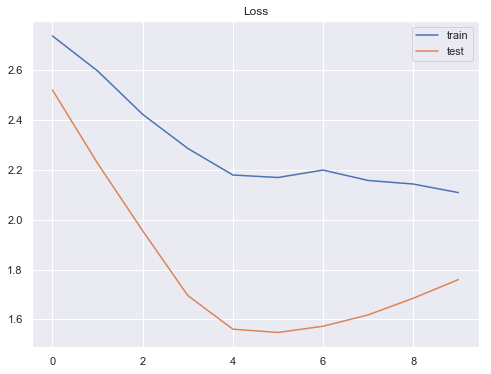

In [562]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

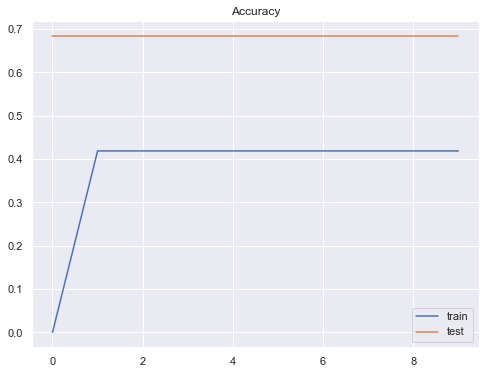

In [563]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();